# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: Lectures 2 and 3 

**Due date: Tuesday, May 24, 2022 at 18:00**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

## Instructions
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). In particular, **see the note about not pushing downloaded data to your repo**.

You are welcome to broadly discuss questions with your classmates but your final answers must be your own. **We are not allowing group submission for this homework assignment.**  

## Introducing the data set
 
For this  assignment you'll be looking at Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/) dataset.
The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it to the same directory as this notebook.

## Exercise 1: Exploratory data analysis

#### 1(a) 
rubric={points:2}

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index.

In [2]:
spotify_df = pd.read_csv('spotify.csv', index_col=0)
# spotify_df

#### 1(b)
rubric={points:2}

Run the following line of code to split the data. How many training and test examples do we have?

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [3]:
df_train, df_test = train_test_split(spotify_df, test_size=0.25, random_state=123)
#505 test data points, and 1512 training examples

#### 1(c)
rubric={points:3}

- Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
- Which feature has the smallest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.

Note that `describe` returns another DataFrame.

In [4]:
df_train.describe().loc['max'] - df_train.describe().loc['min']
#Speechiness has the smallest range

acousticness             0.994995
danceability             0.862000
duration_ms         833918.000000
energy                   0.982200
instrumentalness         0.976000
key                     11.000000
liveness                 0.950200
loudness                32.790000
mode                     1.000000
speechiness              0.792900
tempo                  171.472000
time_signature           4.000000
valence                  0.956100
target                   1.000000
dtype: float64

#### 1(d) 
rubric={points:5}

Let's focus on the following features:

- danceability
- tempo
- energy
- valence

For each of these features (in order), produce a histogram that shows the distribution of the feature values in the training set, **separated for positive and negative examples**. 
By "positive examples" we mean target = 1 (user liked the song, positive sentiment) and by "negative examples" we mean target = 0 (used disliked the song, negative sentiment). As an example, here is what the histogram would look like for a different feature, loudness:



<img src='loudness.png' width="400">

(You don't have to match all the details exactly, such as colour, but your histograms should look something like this, with a reasonable number of bins to see the shape of the distribution.) As shown above, there are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram above shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of your loop, which draws the figure and resets the canvas for your next plot.

Here is some code that separates out the dataset into positive and negative examples, to help you get started:

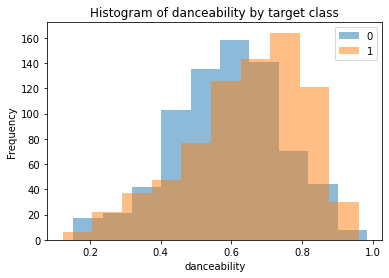

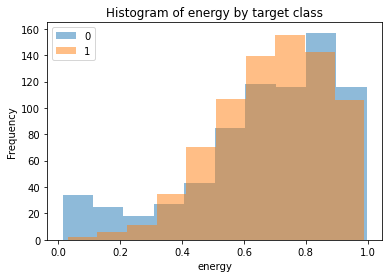

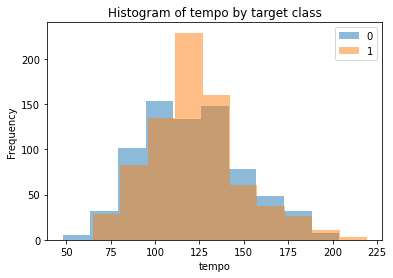

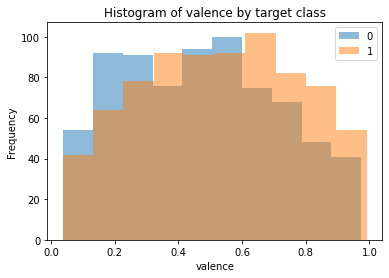

In [5]:
negative_examples = df_train.query("target == 0")
positive_examples = df_train.query("target == 1")

negative_targets = negative_examples[['danceability','energy','tempo','valence']]
positive_targets = positive_examples[['danceability','energy','tempo','valence']]

for column in negative_targets.columns:
    negative_examples[column].plot.hist(title='Histogram of ' + column + ' by target class',alpha=0.5)
    positive_examples[column].plot.hist(alpha=0.5)
    plt.xlabel(column)
    plt.legend(['0','1'])
    plt.show()

#for loop
    #get column name and append into the title
    #intialize axis titles
    #and basic legend
    #plot negative examples
    #plot positive examples on same graph
    #end with plt.show()

#### 1(e)
rubric={points:4}

Let's say you had to make a decision stump (decision tree with depth 1), _by hand_, to predict the target class. Just from looking at the plots above, describe a reasonable split (feature name and threshold) and what class you would predict in the two cases. For example, in the loudness histogram provided earlier on, it seems that very large values of loudness are generally disliked (more blue on the right side of the histogram), so you might answer something like this: "A reasonable split would be to predict 0 if loudness > -5 (and predict 1 otherwise)."

A resonable split would be to predict 0 if danceability <= 0.6 and predict 1 otherwise

#### 1(f)
rubric={points:2}

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?

If the histograms are identical, then there is no way to algorithmically predict the target class for a given song.

#### 1(g) 
rubric={points:2}

Note that the dataset includes two free text features labeled `song_title` and `artist`:

In [6]:
df_train[["song_title", "artist"]].head()

,song_title,artist
1396,All in Vain,Mot
641,One of Those Nights,Juicy J
1765,Take Me As I Am,Wyclef Jean
1801,Save My Soul,JoJo
1624,Save the World - Radio Mix,Swedish House Mafia


- Do you think these features could be useful in predicting whether the user liked the song or not? 
- Would there be any difficulty in using them in your model?   

In this particular model, they are not useful in isolation. They could be useful if we knew a given user's preferences (i.e. you liked this song by this artist, maybe you'll like this other song from the same album). Incorporating them into the dataset wouldn't break the model, but to actually use them would be difficult

<br><br>

## Exercise 2: Using sklearn to build a decision tree classifier

#### 2(a) 
rubric={points:2}

- Create `X_train` and `y_train` and `X_test` and `y_test` from `df_train` and `df_test` above. Skip the `song_title` and `artist` features for now. 
- Fit a `DecisionTreeClassifier` on the train set.

In [7]:
X_train, y_train = df_train.drop(columns=['target','song_title','artist']), df_train['target']
X_test, y_test = df_test.drop(columns=['target','song_title','artist']), df_test['target']

model = DecisionTreeClassifier()
model.fit(X = X_train, y = y_train)

DecisionTreeClassifier()

#### 2(b)
rubric={points:2}

Use the `predict` method to predict the class of the first example in your `X_train`. Is the prediction correct? That is, does it match with the corresponding class in `y_train`?  

> Hint: you can grab the first example with `X_train.iloc[[0]]`.

In [8]:
print(model.predict(X_train.iloc[[0]]))
y_train
#success! and it matches down the list

[0]


1396    0
641     1
1765    0
1801    0
1624    0
       ..
2012    0
1346    0
1406    0
1389    0
1534    0
Name: target, Length: 1512, dtype: int64

#### 2(c) 
rubric={points:2}

Use the `cross_val_score` function on your training set to compute the 10-fold cross-validation accuracy of your tree. 

In [9]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
cv_scores

array([0.67105263, 0.66447368, 0.68211921, 0.65562914, 0.66887417,
       0.68211921, 0.67549669, 0.64238411, 0.71523179, 0.70198675])

#### 2(d)
rubric={points:2}

The above is useful, but we would like to see the training accuracy as well. 

- Compute the 10-fold cross-validation again but this time using the `cross_validate` function with `return_train_score=True`. 
- Print out both the cross-validation score and the training score.
- Is your cross-validation score exactly the same as what you got in the previous part? Very briefly discuss.

In [10]:
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)

print('there is a shared data point between the two, but it is mostly different scores. That said, both are a similar range')

there is a shared data point between the two, but it is mostly different scores. That said, both are a similar range


#### 2(e)
rubric={points:1}

Do you see a significant difference between the training score and the cross-validation score? Briefly discuss.

There is a significant differnece between the training score and the test score, with the training score being nearly perfect while the test score's percentage hovering around the mid-60s

#### 2(f)
rubric={points:1}

Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your cross validation score?

It tells me that the model is overfitted to the training dataset, and is therefore not able to generalize effectively.

## Exercise 3: Hyperparameters 
rubric={points:10}

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

- Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25).
- For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
- Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which.
- Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. From these results, what depth would you pick as the optimal depth? 
- Do you think that the depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

In [11]:
#Code adapted from Lecture 3
results_dict = {
    "depth": [],
    "mean_train_error": [],
    "mean_cv_error": [],
    "std_cv_error": [],
    "std_train_error": [],
}
param_grid = {"max_depth": np.arange(1, 26)}

for depth in param_grid["max_depth"]:
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_error"].append(1 - np.mean(scores["test_score"]))
    results_dict["mean_train_error"].append(1 - np.mean(scores["train_score"]))
    results_dict["std_cv_error"].append(scores["test_score"].std())
    results_dict["std_train_error"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("depth")

<AxesSubplot:title={'center':'Training Error and CV Error vs. Classifer Depth'}, xlabel='depth', ylabel='score'>

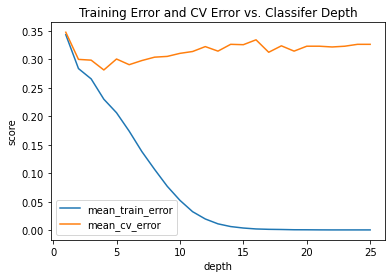

In [12]:
results_df[['mean_train_error','mean_cv_error']].plot(ylabel='score', title='Training Error and CV Error vs. Classifer Depth')

As we go deeper with our classifier tree, the training error approaches 0, but the CV score increases slightly as the model specializes for the training dataset. For this dataset, I would choose a max_depth = 4, due to it having the lowest CV error and being in the sweetspot where the two are begining to diverge.

## Exercise 4: Test set
rubric={points:4}

Remember the test set you created way back at the beginning of this assignment? Let's use it now to see if our cross-validation score from the previous exercise is trustworthy. 

- Select your favorite `max_depth` from the previous part.
- Train a decision tree classifier using that `max_depth` on the _entire training set_.
- Compute and display the test score. 
- How does it compare to the cross-validation score from the previous exercise? Briefly discuss. 

In [13]:
new_model = DecisionTreeClassifier(max_depth=4)
new_model.fit(X_train, y_train)
new_scores = cross_validate(new_model, X_train, y_train, cv=10, return_train_score=True)

pd.DataFrame(new_scores)

,fit_time,score_time,test_score,train_score
0,0.029847,0.005008,0.723684,0.772794
1,0.026997,0.005131,0.684211,0.781618
2,0.027993,0.003972,0.715232,0.769287
3,0.026632,0.004092,0.715232,0.770022
4,0.026002,0.004995,0.728477,0.767083
5,0.027000,0.005004,0.675497,0.765614
6,0.029192,0.005008,0.708609,0.772226
7,0.027997,0.005085,0.735099,0.770022
8,0.028165,0.004005,0.728477,0.770757
9,0.028995,0.004022,0.774834,0.762675


There has been a significant improvement over the intial model in the testing group, but less accurate with the training group. 

## Exercise 5: Conceptual questions
rubric={points:3}

Consider the dataset below, which has $6$ examples and $2$ features:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}-1\\-1\\+1\\+1\\+1\\+1\end{bmatrix}.$$

1. Say we fit a decision stump (depth 1 decision tree) and the first split is on the first feature (left column) being less than 5.5. What would we predict in the "true" and "false" cases here?
2. What training accuracy would the above stump get on this data set?
3. Can we obtain 100% accuracy with a single decision stump in this particular example?

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 